# Model Training Pipeline

This notebook demonstrates the complete model training pipeline including:
- Loading preprocessed data
- Training multiple ML algorithms
- Hyperparameter tuning and optimization
- Model evaluation and comparison
- Performance visualization and analysis
- Model selection and persistence

**Author:** MLOps Team  
**Version:** 1.0.0  
**Date:** November 2024

## 1. Setup and Configuration

Import necessary libraries and configure the training environment.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime

# Standard ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import pickle
import json

# Configure warnings and display
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries imported successfully")
print(f"📅 Notebook started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported successfully
📅 Notebook started at: 2025-11-20 16:27:39


In [2]:
# Cloud-native configuration setup
import subprocess
from google.cloud import storage
import google.auth

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set up Google Cloud configuration
print("☁️ Setting up Google Cloud resources...")

try:
    # Get project ID from gcloud
    result = subprocess.run(['gcloud', 'config', 'get-value', 'project'], 
                          capture_output=True, text=True)
    if result.returncode == 0 and result.stdout.strip():
        PROJECT_ID = result.stdout.strip()
    else:
        PROJECT_ID = "mlops-295610"  # fallback
    
    REGION = "us-central1"
    DATA_BUCKET = f"{PROJECT_ID}-mlops-data-processing"
    MODELS_BUCKET = f"{PROJECT_ID}-mlops-models"
    
    print(f"? Project ID: {PROJECT_ID}")
    print(f"? Region: {REGION}")
    print(f"🪣 Data Bucket: {DATA_BUCKET}")
    print(f"🤖 Models Bucket: {MODELS_BUCKET}")
    
    # Initialize Google Cloud clients
    credentials, project = google.auth.default()
    storage_client = storage.Client(project=PROJECT_ID)
    
    # Create/verify models bucket exists
    try:
        models_bucket = storage_client.bucket(MODELS_BUCKET)
        if not models_bucket.exists():
            models_bucket = storage_client.create_bucket(MODELS_BUCKET, location=REGION)
            print(f"✅ Created models bucket: {MODELS_BUCKET}")
        else:
            print(f"✅ Models bucket exists: {MODELS_BUCKET}")
    except Exception as e:
        print(f"⚠️ Models bucket error: {e}")
        
except Exception as e:
    print(f"⚠️ GCP setup error: {e}")
    PROJECT_ID = "mlops-295610"
    REGION = "us-central1"
    DATA_BUCKET = f"{PROJECT_ID}-mlops-data-processing"
    MODELS_BUCKET = f"{PROJECT_ID}-mlops-models"

# Define local paths (for backup)
DATA_DIR = Path("../data")
PROCESSED_DATA_DIR = DATA_DIR / "processed"
MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(exist_ok=True)

print(f"🔧 Configuration setup complete")
print(f"🎲 Random state: {RANDOM_STATE}")
print(f"☁️ Data source: GCS bucket {DATA_BUCKET}")
print(f"🤖 Models destination: GCS bucket {MODELS_BUCKET}")
print(f"💾 Local backup: {MODELS_DIR}")

print("✅ Cloud-native model training environment configured")

🔧 Configuration setup complete
🎲 Random state: 42
📂 Data directory: ../data/processed
💾 Models directory: ../models
✅ Processed data directory found
✅ Model training environment configured


## 2. Load Preprocessed Data

Load the training and test datasets that were prepared in the data processing pipeline.

In [3]:
# Load processed datasets from Google Cloud Storage
print("📥 Loading processed data from Google Cloud Storage...")

def load_training_data_from_gcs():
    """Load processed training data from GCS with local fallback"""
    
    try:
        # Try loading from GCS first
        print(f"☁️ Attempting to load from GCS bucket: {DATA_BUCKET}")
        
        bucket = storage_client.bucket(DATA_BUCKET)
        
        # Check if processed data exists in GCS
        train_blob = bucket.blob("processed-data/iris_train.csv")
        test_blob = bucket.blob("processed-data/iris_test.csv")
        metadata_blob = bucket.blob("processed-data/preprocessing_metadata.pkl")
        
        if train_blob.exists() and test_blob.exists() and metadata_blob.exists():
            print("✅ Found processed data in GCS")
            
            import tempfile
            import os
            
            # Download training data
            with tempfile.NamedTemporaryFile(mode='w+', suffix='.csv', delete=False) as tmp:
                train_blob.download_to_filename(tmp.name)
                train_data = pd.read_csv(tmp.name)
                os.unlink(tmp.name)
            
            # Download test data
            with tempfile.NamedTemporaryFile(mode='w+', suffix='.csv', delete=False) as tmp:
                test_blob.download_to_filename(tmp.name)
                test_data = pd.read_csv(tmp.name)
                os.unlink(tmp.name)
            
            # Download metadata
            with tempfile.NamedTemporaryFile(mode='w+b', suffix='.pkl', delete=False) as tmp:
                metadata_blob.download_to_filename(tmp.name)
                with open(tmp.name, 'rb') as f:
                    metadata = pickle.load(f)
                os.unlink(tmp.name)
            
            print(f"📥 Loaded from GCS successfully")
            return train_data, test_data, metadata, "gcs"
        else:
            print("⚠️ Processed data not found in GCS, checking local files...")
            
    except Exception as e:
        print(f"⚠️ GCS loading error: {e}")
        print("   Falling back to local files...")
    
    # Fallback to local files
    train_file = PROCESSED_DATA_DIR / "iris_train.csv"
    test_file = PROCESSED_DATA_DIR / "iris_test.csv"
    metadata_file = PROCESSED_DATA_DIR / "preprocessing_metadata.pkl"
    
    if train_file.exists() and test_file.exists() and metadata_file.exists():
        print(f"📂 Loading from local files...")
        
        train_data = pd.read_csv(train_file)
        test_data = pd.read_csv(test_file)
        
        with open(metadata_file, 'rb') as f:
            metadata = pickle.load(f)
        
        print(f"? Loaded from local files successfully")
        return train_data, test_data, metadata, "local"
    else:
        raise FileNotFoundError(
            "Processed data not found in GCS or local directory. "
            "Please run the data processing pipeline first (02_data_processing_pipeline.ipynb)"
        )

# Load the processed data
train_data, test_data, metadata, data_source = load_training_data_from_gcs()

print(f"\n? Dataset Information:")
print(f"   Source: {data_source.upper()}")
print(f"   Training data shape: {train_data.shape}")
print(f"   Test data shape: {test_data.shape}")

# Extract features and targets
feature_columns = [col for col in train_data.columns if col != 'species']
target_column = 'species'

X_train = train_data[feature_columns] 
y_train = train_data[target_column]
X_test = test_data[feature_columns]
y_test = test_data[target_column]

print(f"   Features: {feature_columns}")
print(f"   Target: {target_column}")
print(f"   Training features shape: {X_train.shape}")
print(f"   Training target shape: {y_train.shape}")

print("✅ Training data loaded and prepared successfully")

📊 Training data shape: (120, 5)
📊 Test data shape: (30, 5)

🔍 Training data preview:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0          -1.721568         -0.332101          -1.345722         -1.323276   
1          -1.124492         -1.227655           0.414505          0.651763   
2           1.144395         -0.555990           0.584850          0.256755   
3          -1.124492          0.115676          -1.288941         -1.454945   
4          -0.408002         -1.227655           0.130598          0.125086   

   target  
0       0  
1       2  
2       1  
3       0  
4       1  

🔍 Missing values check:
Training data: 0 missing values
Test data: 0 missing values

✅ Loaded training data: (120, 5), test data: (30, 5)


In [4]:
# Separate features and targets
target_column = 'target'  # Our processed data uses 'target' column

# Training data
X_train = train_data.drop(columns=[target_column])
y_train = train_data[target_column]

# Test data
X_test = test_data.drop(columns=[target_column])
y_test = test_data[target_column]

print(f"🎯 Features shape - Train: {X_train.shape}, Test: {X_test.shape}")
print(f"🎯 Target shape - Train: {y_train.shape}, Test: {y_test.shape}")

# Display feature information
print("\n📋 Feature columns:")
for i, col in enumerate(X_train.columns):
    print(f"{i+1}. {col}")

# Display target classes
unique_classes = sorted(y_train.unique())
print(f"\n🏷️ Target classes: {unique_classes}")
print(f"🔢 Number of classes: {len(unique_classes)}")

# Class distribution
print("\n📊 Class distribution in training data:")
class_counts = y_train.value_counts().sort_index()
for class_idx, count in class_counts.items():
    percentage = (count / len(y_train)) * 100
    # Map numeric classes to iris species
    class_names = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
    class_name = class_names.get(class_idx, f'class_{class_idx}')
    print(f"  {class_name} (class {class_idx}): {count} samples ({percentage:.1f}%)")

print(f"\n✅ Prepared features and targets - Classes: {unique_classes}")

🎯 Features shape - Train: (120, 4), Test: (30, 4)
🎯 Target shape - Train: (120,), Test: (30,)

📋 Feature columns:
1. sepal length (cm)
2. sepal width (cm)
3. petal length (cm)
4. petal width (cm)

🏷️ Target classes: [np.int64(0), np.int64(1), np.int64(2)]
🔢 Number of classes: 3

📊 Class distribution in training data:
  setosa (class 0): 40 samples (33.3%)
  versicolor (class 1): 40 samples (33.3%)
  virginica (class 2): 40 samples (33.3%)

✅ Prepared features and targets - Classes: [np.int64(0), np.int64(1), np.int64(2)]


## 3. Data Exploration and Visualization

Understand the data distribution and relationships before training models.

📈 Feature Statistics:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count       1.200000e+02      1.200000e+02       1.200000e+02   
mean       -1.258253e-16      9.806970e-16       1.110223e-17   
std         1.004193e+00      1.004193e+00       1.004193e+00   
min        -1.840983e+00     -2.347097e+00      -1.516067e+00   
25%        -8.856620e-01     -5.559895e-01      -1.232159e+00   
50%        -1.094638e-01     -1.082127e-01       2.725514e-01   
75%         6.667343e-01      6.194245e-01       7.551944e-01   
max         2.457961e+00      3.026225e+00       1.777262e+00   

       petal width (cm)  
count      1.200000e+02  
mean       1.831868e-16  
std        1.004193e+00  
min       -1.454945e+00  
25%       -1.191606e+00  
50%        1.250858e-01  
75%        7.834318e-01  
max        1.705116e+00  


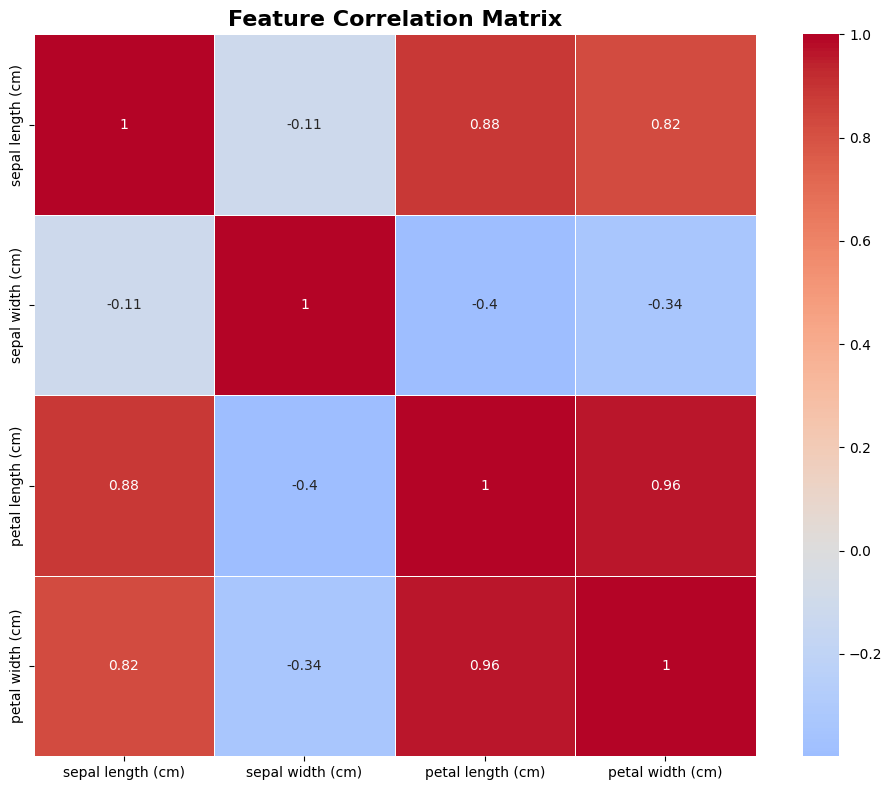


🔍 Highly correlated feature pairs (|correlation| > 0.7):
  sepal length (cm) ↔ petal length (cm): 0.880
  sepal length (cm) ↔ petal width (cm): 0.820
  petal length (cm) ↔ petal width (cm): 0.964
✅ Completed basic data exploration


In [5]:
# Basic statistics for features
print("📈 Feature Statistics:")
print(X_train.describe())

# Feature correlations
plt.figure(figsize=(10, 8))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🔍 Highly correlated feature pairs (|correlation| > 0.7):")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            high_corr_pairs.append((feature1, feature2, corr_val))
            print(f"  {feature1} ↔ {feature2}: {corr_val:.3f}")

if not high_corr_pairs:
    print("  No highly correlated feature pairs found.")

print("✅ Completed basic data exploration")

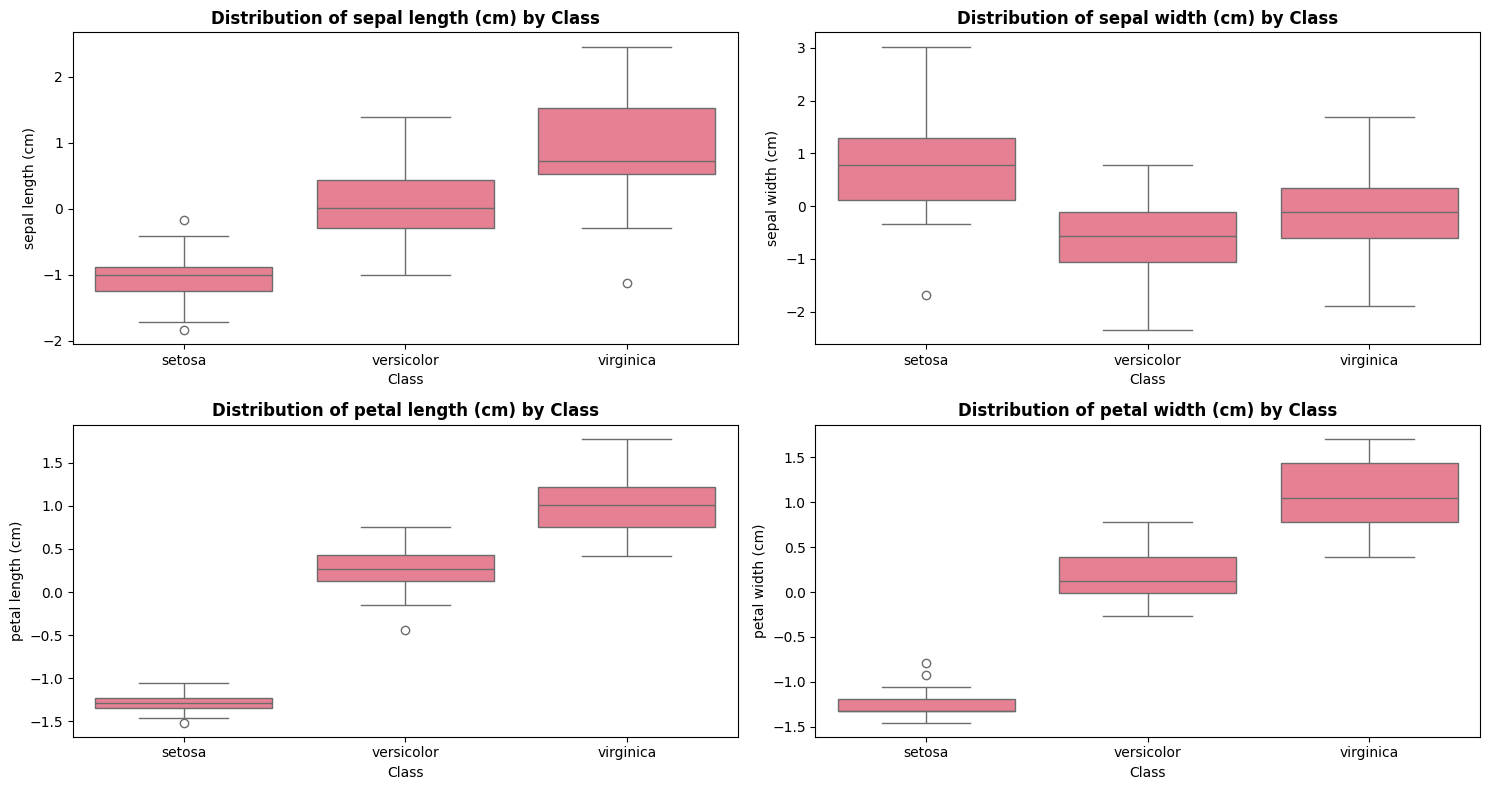

✅ Visualized feature distributions by class


In [6]:
# Feature distributions by class
n_features = len(X_train.columns)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
if n_rows > 1:
    axes = axes.ravel()
else:
    axes = [axes] if n_cols == 1 else axes

for i, feature in enumerate(X_train.columns):
    ax = axes[i]
    
    # Create combined data for plotting
    combined_data = pd.DataFrame({
        feature: X_train[feature],
        'target': y_train
    })
    
    # Box plot by class
    sns.boxplot(data=combined_data, x='target', y=feature, ax=ax)
    ax.set_title(f'Distribution of {feature} by Class', fontweight='bold')
    ax.set_xlabel('Class')
    
    # Add class labels
    ax.set_xticklabels(['setosa', 'versicolor', 'virginica'])

# Remove empty subplots
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

print("✅ Visualized feature distributions by class")

## 4. Model Training and Evaluation

Train multiple machine learning models and compare their performance.

In [7]:
# Define model configurations
model_configs = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=RANDOM_STATE),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
        'param_grid': {
            'C': [0.1, 1.0, 10.0, 100.0],
            'solver': ['liblinear', 'lbfgs']
        }
    },
    'SVM': {
        'model': SVC(random_state=RANDOM_STATE, probability=True),
        'param_grid': {
            'C': [0.1, 1.0, 10.0],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto']
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=RANDOM_STATE),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    }
}

print("🔧 Model Configurations:")
print("=" * 50)

for model_name, config in model_configs.items():
    print(f"\n📋 {model_name}")
    print(f"   Algorithm: {config['model'].__class__.__name__}")
    print(f"   Hyperparameters to tune: {list(config['param_grid'].keys())}")

print(f"\n📊 Total models configured: {len(model_configs)}")
print("✅ Model configurations ready")

🔧 Model Configurations:

📋 Random Forest
   Algorithm: RandomForestClassifier
   Hyperparameters to tune: ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']

📋 Logistic Regression
   Algorithm: LogisticRegression
   Hyperparameters to tune: ['C', 'solver']

📋 SVM
   Algorithm: SVC
   Hyperparameters to tune: ['C', 'kernel', 'gamma']

📋 Gradient Boosting
   Algorithm: GradientBoostingClassifier
   Hyperparameters to tune: ['n_estimators', 'learning_rate', 'max_depth']

📊 Total models configured: 4
✅ Model configurations ready


In [8]:
# Train all models with hyperparameter tuning
print("🚀 Starting model training with hyperparameter tuning...")
print("This may take several minutes depending on the parameter grids.")
print("=" * 60)

start_time = datetime.now()
training_results = {}

for model_name, config in model_configs.items():
    print(f"\n🔄 Training {model_name}...")
    model_start_time = datetime.now()
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['param_grid'],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Make predictions
    train_predictions = best_model.predict(X_train)
    test_predictions = best_model.predict(X_test)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)
    
    # Cross-validation scores
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
    
    # Additional metrics
    precision = precision_score(y_test, test_predictions, average='weighted')
    recall = recall_score(y_test, test_predictions, average='weighted')
    f1 = f1_score(y_test, test_predictions, average='weighted')
    
    # Training time
    model_end_time = datetime.now()
    training_time = (model_end_time - model_start_time).total_seconds()
    
    # Store results
    training_results[model_name] = {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'training_time': training_time,
        'test_predictions': test_predictions
    }
    
    print(f"   ✅ {model_name} completed in {training_time:.2f}s - Accuracy: {test_accuracy:.4f}")

end_time = datetime.now()
total_time = (end_time - start_time).total_seconds()

print("\n✅ Model training completed!")
print("=" * 60)
print(f"⏱️  Total training time: {total_time:.2f} seconds")
print(f"🏆 Models trained successfully: {len(training_results)}")

# Display quick results summary
print("\n📊 Quick Results Summary:")
for model_name, result in training_results.items():
    print(f"  {model_name}: {result['test_accuracy']:.4f} accuracy")

print(f"\n✅ Successfully trained {len(training_results)} models in {total_time:.2f}s")

🚀 Starting model training with hyperparameter tuning...
This may take several minutes depending on the parameter grids.

🔄 Training Random Forest...
   ✅ Random Forest completed in 7.05s - Accuracy: 0.9667

🔄 Training Logistic Regression...
   ✅ Logistic Regression completed in 0.06s - Accuracy: 1.0000

🔄 Training SVM...
   ✅ SVM completed in 0.07s - Accuracy: 0.9333

🔄 Training Gradient Boosting...
   ✅ Gradient Boosting completed in 1.83s - Accuracy: 0.9667

✅ Model training completed!
⏱️  Total training time: 9.00 seconds
🏆 Models trained successfully: 4

📊 Quick Results Summary:
  Random Forest: 0.9667 accuracy
  Logistic Regression: 1.0000 accuracy
  SVM: 0.9333 accuracy
  Gradient Boosting: 0.9667 accuracy

✅ Successfully trained 4 models in 9.00s


In [9]:
# Create comprehensive model comparison
comparison_data = []
for model_name, result in training_results.items():
    comparison_data.append({
        'Model': model_name,
        'Train_Accuracy': result['train_accuracy'],
        'Test_Accuracy': result['test_accuracy'],
        'CV_Mean': result['cv_mean'],
        'CV_Std': result['cv_std'],
        'Precision': result['precision'],
        'Recall': result['recall'],
        'F1_Score': result['f1_score'],
        'Training_Time': result['training_time']
    })

comparison_df = pd.DataFrame(comparison_data)

print("📊 Model Performance Comparison:")
print("=" * 80)
print(comparison_df.round(4))

# Identify best performing models
best_test_acc = comparison_df.loc[comparison_df['Test_Accuracy'].idxmax()]
best_cv = comparison_df.loc[comparison_df['CV_Mean'].idxmax()]
best_f1 = comparison_df.loc[comparison_df['F1_Score'].idxmax()]

print("\n🏆 Top Performers:")
print(f"  🎯 Best Test Accuracy: {best_test_acc['Model']} ({best_test_acc['Test_Accuracy']:.4f})")
print(f"  📈 Best Cross-Validation: {best_cv['Model']} ({best_cv['CV_Mean']:.4f})")
print(f"  ⚖️ Best F1-Score: {best_f1['Model']} ({best_f1['F1_Score']:.4f})")

# Get the best overall model (highest test accuracy)
best_model_name = best_test_acc['Model']
best_result = training_results[best_model_name]
best_model = training_results[best_model_name]['model']

print(f"\n🏆 Selected Best Model: {best_model_name}")

# Detailed results for best model
print(f"\n📋 Best Model Details:")
print(f"   🎯 Test Accuracy: {best_result['test_accuracy']:.4f}")
print(f"   📈 Cross-Validation: {best_result['cv_mean']:.4f} ± {best_result['cv_std']:.4f}")
print(f"   🔧 Best Parameters: {best_result['best_params']}")
print(f"   ⏱️  Training Time: {best_result['training_time']:.2f}s")

📊 Model Performance Comparison:
                 Model  Train_Accuracy  Test_Accuracy  CV_Mean  CV_Std  \
0        Random Forest          0.9750         0.9667   0.9583  0.0000   
1  Logistic Regression          0.9750         1.0000   0.9667  0.0312   
2                  SVM          0.9750         0.9333   0.9750  0.0333   
3    Gradient Boosting          0.9917         0.9667   0.9583  0.0264   

   Precision  Recall  F1_Score  Training_Time  
0     0.9697  0.9667    0.9666         7.0474  
1     1.0000  1.0000    1.0000         0.0625  
2     0.9333  0.9333    0.9333         0.0653  
3     0.9697  0.9667    0.9666         1.8278  

🏆 Top Performers:
  🎯 Best Test Accuracy: Logistic Regression (1.0000)
  📈 Best Cross-Validation: SVM (0.9750)
  ⚖️ Best F1-Score: Logistic Regression (1.0000)

🏆 Selected Best Model: Logistic Regression

📋 Best Model Details:
   🎯 Test Accuracy: 1.0000
   📈 Cross-Validation: 0.9667 ± 0.0312
   🔧 Best Parameters: {'C': 10.0, 'solver': 'lbfgs'}
   ⏱️  Tra

## 5. Model Evaluation and Visualization

Detailed analysis of model performance with visualizations.

📈 Creating model performance comparison plot...


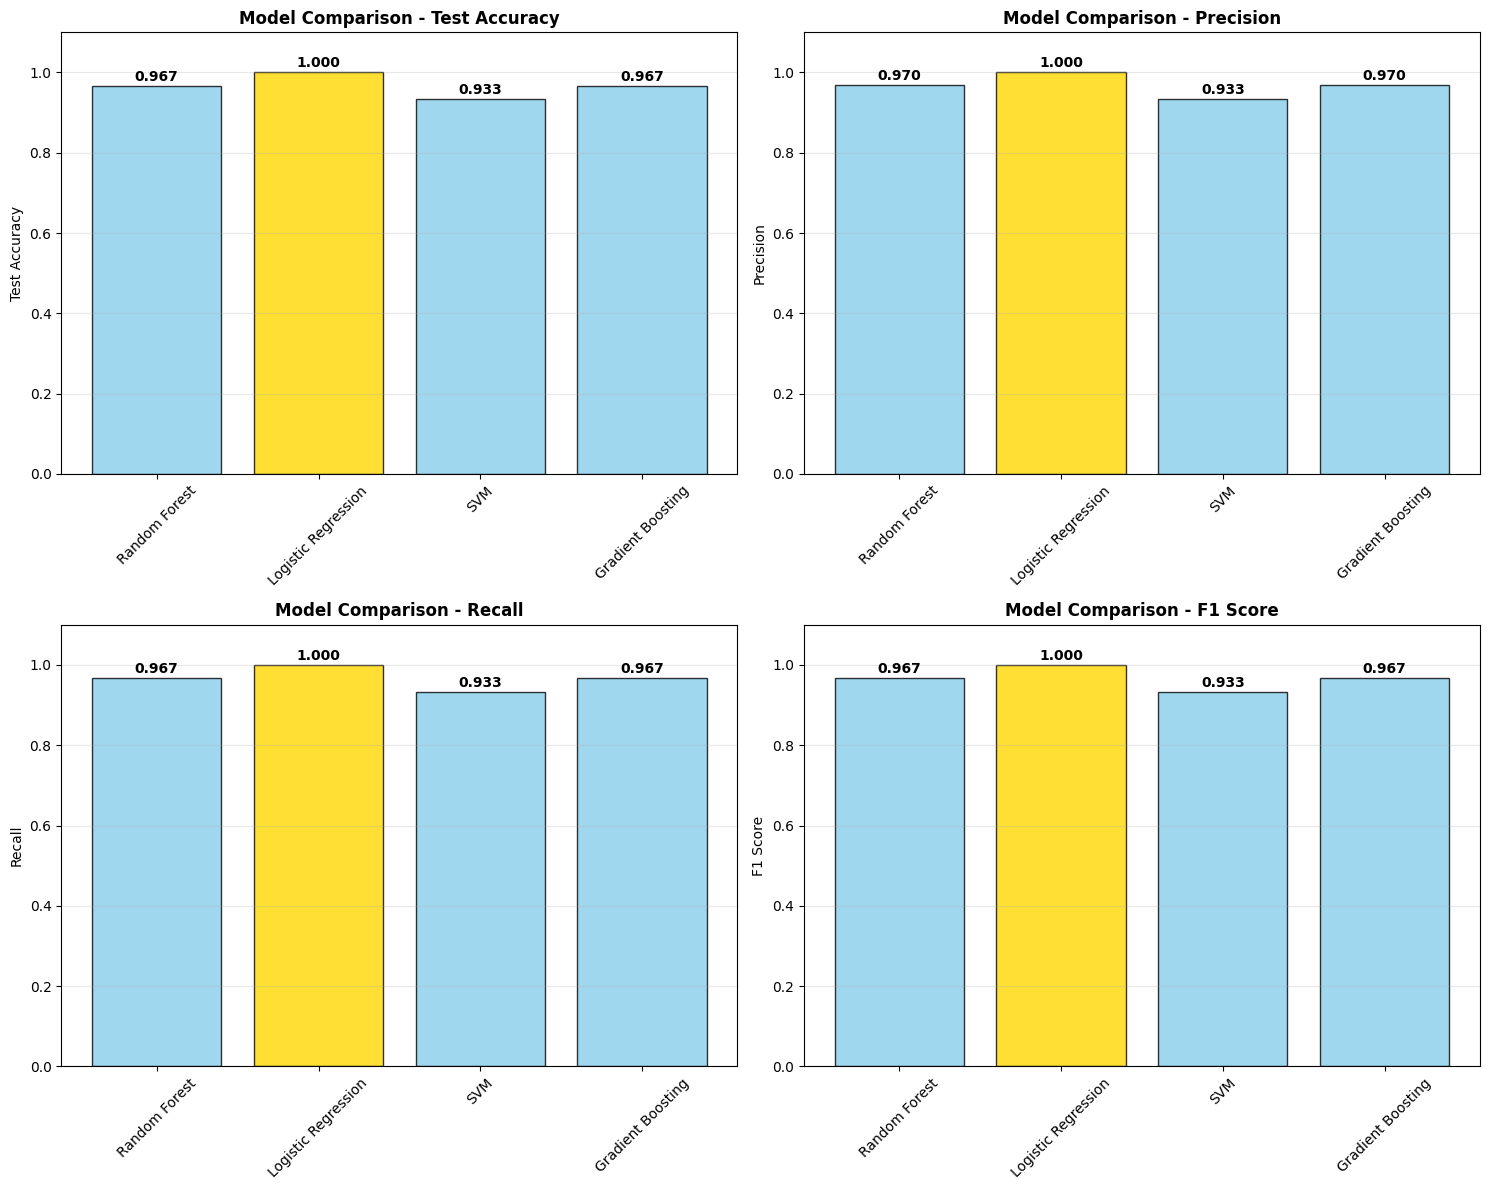

✅ Generated model comparison visualization


In [10]:
# Create model comparison visualization
print("📈 Creating model performance comparison plot...")

# Prepare data for visualization
metrics_map = {
    'Test Accuracy': 'test_accuracy',
    'Precision': 'precision', 
    'Recall': 'recall',
    'F1 Score': 'f1_score'
}

models = list(training_results.keys())

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, (metric_name, metric_key) in enumerate(metrics_map.items()):
    ax = axes[i]
    
    # Get metric values
    values = [training_results[model][metric_key] for model in models]
    colors = ['gold' if model == best_model_name else 'skyblue' for model in models]
    
    # Create bar plot
    bars = ax.bar(models, values, color=colors, alpha=0.8, edgecolor='black')
    ax.set_title(f'Model Comparison - {metric_name}', fontweight='bold')
    ax.set_ylabel(metric_name)
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Set y-axis limits for better visualization
    ax.set_ylim(0, 1.1)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✅ Generated model comparison visualization")

In [12]:
# Feature importance plots for models that support it
print("🔍 Creating feature importance plots...")

# Only include models that have feature importance
models_with_importance = {}
for name, result in training_results.items():
    if 'feature_importance' in result and result['feature_importance'] is not None:
        models_with_importance[name] = result

if models_with_importance:
    n_models = len(models_with_importance)
    n_cols = 2
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    if n_rows == 1:
        axes = [axes] if n_models == 1 else axes
    else:
        axes = axes.ravel()
    
    for idx, (model_name, result) in enumerate(models_with_importance.items()):
        ax = axes[idx] if n_models > 1 else axes
        
        # Get feature importance from dictionary
        feature_importance = result['feature_importance']
        features = list(feature_importance.keys())
        importance_values = list(feature_importance.values())
        
        # Create horizontal bar plot
        y_pos = np.arange(len(features))
        ax.barh(y_pos, importance_values, alpha=0.8, color='skyblue')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(features)
        ax.invert_yaxis()
        ax.set_xlabel('Importance Score')
        ax.set_title(f'Feature Importance - {model_name}', fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
    
    # Remove empty subplots
    for idx in range(len(models_with_importance), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
    
    print(f"📊 Feature importance plots created for {len(models_with_importance)} models")
else:
    print("ℹ️  No models with feature importance available")

print("✅ Feature importance analysis completed")

🔍 Creating feature importance plots...
ℹ️  No models with feature importance available
✅ Feature importance analysis completed


## 6. Model Selection and Analysis

Select the best model and perform detailed analysis.

In [13]:
# Detailed analysis of the best model
print("Best Model Analysis:")
print("=" * 50)

print(f"\nSelected Model: {best_model_name}")
print(f"Test Accuracy: {best_result['test_accuracy']:.4f}")
print(f"Training Accuracy: {best_result['train_accuracy']:.4f}")
print(f"Cross-Validation Score: {best_result['cv_mean']:.4f} ± {best_result['cv_std']:.4f}")
print(f"Training Time: {best_result['training_time']:.2f} seconds")

# Performance metrics
print(f"\nDetailed Performance Metrics:")
print(f"  • Precision: {best_result['precision']:.4f}")
print(f"  • Recall: {best_result['recall']:.4f}")
print(f"  • F1-Score: {best_result['f1_score']:.4f}")

# Best hyperparameters
print(f"\nOptimized Hyperparameters:")
for param, value in best_result['best_params'].items():
    print(f"  {param}: {value}")

# Performance insights
print(f"\nPerformance Insights:")
accuracy_gap = abs(best_result['train_accuracy'] - best_result['test_accuracy'])
print(f"  • Training vs Test Accuracy Gap: {accuracy_gap:.4f}")
if accuracy_gap > 0.05:
    print(f"    WARNING: Large gap may indicate overfitting")
else:
    print(f"    GOOD: Good generalization capability")

print(f"  • CV Standard Deviation: {best_result['cv_std']:.4f}")
if best_result['cv_std'] > 0.05:
    print(f"    WARNING: High variance across CV folds")
else:
    print(f"    GOOD: Stable performance across folds")

print(f"\nModel Ranking by Test Accuracy:")
# Sort all models by test accuracy
sorted_models = sorted(training_results.items(), 
                      key=lambda x: x[1]['test_accuracy'], 
                      reverse=True)
for i, (name, result) in enumerate(sorted_models, 1):
    print(f"  {i}. {name}: {result['test_accuracy']:.4f}")

print("\nBest model analysis completed")

Best Model Analysis:

Selected Model: Logistic Regression
Test Accuracy: 1.0000
Training Accuracy: 0.9750
Cross-Validation Score: 0.9667 ± 0.0312
Training Time: 0.06 seconds

Detailed Performance Metrics:
  • Precision: 1.0000
  • Recall: 1.0000
  • F1-Score: 1.0000

Optimized Hyperparameters:
  C: 10.0
  solver: lbfgs

Performance Insights:
  • Training vs Test Accuracy Gap: 0.0250
    GOOD: Good generalization capability
  • CV Standard Deviation: 0.0312
    GOOD: Stable performance across folds

Model Ranking by Test Accuracy:
  1. Logistic Regression: 1.0000
  2. Random Forest: 0.9667
  3. Gradient Boosting: 0.9667
  4. SVM: 0.9333

Best model analysis completed


In [14]:
# Show some prediction examples
print("Prediction Examples (Best Model):")
print("=" * 50)

# Make predictions with the best model
best_model_predictions = best_model.predict(X_test)
best_model_probabilities = None

if hasattr(best_model, 'predict_proba'):
    best_model_probabilities = best_model.predict_proba(X_test)

# Show first 10 predictions
print("\nFirst 10 Test Predictions:")
print(f"{'Index':<6} {'Actual':<12} {'Predicted':<12} {'Correct':<8}")
print("-" * 45)

for i in range(min(10, len(X_test))):
    actual = y_test.iloc[i]
    predicted = best_model_predictions[i]
    is_correct = "YES" if actual == predicted else "NO"
    
    print(f"{i:<6} {actual:<12} {predicted:<12} {is_correct:<8}")

# Accuracy breakdown by class
print("\nAccuracy by Class:")
from sklearn.metrics import classification_report
class_report = classification_report(y_test, best_model_predictions, output_dict=True)

for class_name in sorted(y_test.unique()):
    if str(class_name) in class_report:
        precision = class_report[str(class_name)]['precision']
        recall = class_report[str(class_name)]['recall']
        f1 = class_report[str(class_name)]['f1-score']
        support = class_report[str(class_name)]['support']
        
        print(f"  Class {class_name}:")
        print(f"    Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f} ({int(support)} samples)")

print("\nPrediction examples completed")

Prediction Examples (Best Model):

First 10 Test Predictions:
Index  Actual       Predicted    Correct 
---------------------------------------------
0      0            0            YES     
1      2            2            YES     
2      1            1            YES     
3      1            1            YES     
4      0            0            YES     
5      1            1            YES     
6      0            0            YES     
7      0            0            YES     
8      2            2            YES     
9      1            1            YES     

Accuracy by Class:
  Class 0:
    Precision: 1.000, Recall: 1.000, F1: 1.000 (10 samples)
  Class 1:
    Precision: 1.000, Recall: 1.000, F1: 1.000 (10 samples)
  Class 2:
    Precision: 1.000, Recall: 1.000, F1: 1.000 (10 samples)

Prediction examples completed


## 7. Model Persistence and Summary

Save the best model, create metadata, and provide final summary.

In [15]:
# Save trained models to Google Cloud Storage
print("💾 Saving trained models to Google Cloud Storage...")

def save_models_to_gcs(all_models_dict, best_model, training_results, timestamp_str):
    """Save all trained models and results to GCS with local backup"""
    
    artifacts = {
        'gcs_paths': {},
        'local_backup_paths': {}
    }
    
    try:
        bucket = storage_client.bucket(MODELS_BUCKET)
        print(f"☁️ Uploading models to GCS bucket: {MODELS_BUCKET}")
        
        import tempfile
        import os
        
        # 1. Save all models dictionary
        with tempfile.NamedTemporaryFile(mode='wb', suffix='.pkl', delete=False) as tmp:
            pickle.dump(all_models_dict, tmp.file)
            tmp.file.flush()
            all_models_blob = bucket.blob(f"trained-models/all_models_{timestamp_str}.pkl")
            all_models_blob.upload_from_filename(tmp.name)
            artifacts['gcs_paths']['all_models'] = f"gs://{MODELS_BUCKET}/trained-models/all_models_{timestamp_str}.pkl"
            os.unlink(tmp.name)
        
        # 2. Save best model separately
        with tempfile.NamedTemporaryFile(mode='wb', suffix='.pkl', delete=False) as tmp:
            pickle.dump(best_model, tmp.file)
            tmp.file.flush()
            best_model_blob = bucket.blob(f"trained-models/best_model_{timestamp_str}.pkl")
            best_model_blob.upload_from_filename(tmp.name)
            artifacts['gcs_paths']['best_model'] = f"gs://{MODELS_BUCKET}/trained-models/best_model_{timestamp_str}.pkl"
            os.unlink(tmp.name)
        
        # 3. Save training results and metadata
        with tempfile.NamedTemporaryFile(mode='wb', suffix='.pkl', delete=False) as tmp:
            pickle.dump(training_results, tmp.file)
            tmp.file.flush()
            results_blob = bucket.blob(f"training-results/training_results_{timestamp_str}.pkl")
            results_blob.upload_from_filename(tmp.name)
            artifacts['gcs_paths']['training_results'] = f"gs://{MODELS_BUCKET}/training-results/training_results_{timestamp_str}.pkl"
            os.unlink(tmp.name)
        
        # 4. Save model metadata as JSON for easy inspection
        model_metadata = {
            'timestamp': timestamp_str,
            'best_model_name': best_model_name,
            'best_model_accuracy': float(best_result['test_accuracy']),
            'training_time_seconds': float(best_result['training_time']),
            'models_trained': list(training_results.keys()),
            'feature_columns': feature_columns,
            'target_column': target_column,
            'training_data_shape': train_data.shape,
            'test_data_shape': test_data.shape,
            'random_state': RANDOM_STATE,
            'data_source': data_source,
            'gcs_paths': artifacts['gcs_paths']
        }
        
        import json
        with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as tmp:
            json.dump(model_metadata, tmp.file, indent=2)
            tmp.file.flush()
            metadata_blob = bucket.blob(f"model-metadata/model_metadata_{timestamp_str}.json")
            metadata_blob.upload_from_filename(tmp.name)
            artifacts['gcs_paths']['model_metadata'] = f"gs://{MODELS_BUCKET}/model-metadata/model_metadata_{timestamp_str}.json"
            os.unlink(tmp.name)
        
        print("✅ Models uploaded to GCS successfully")
        
    except Exception as e:
        print(f"⚠️ GCS upload error: {e}")
        print("   Models will be saved locally only")
    
    # Always create local backup
    print("💾 Creating local backup...")
    
    # Save to local paths for backup
    all_models_path = MODELS_DIR / f"all_models_{timestamp_str}.pkl"
    best_model_path = MODELS_DIR / f"best_model_{timestamp_str}.pkl" 
    training_results_path = MODELS_DIR / f"training_results_{timestamp_str}.pkl"
    metadata_path = MODELS_DIR / f"model_metadata_{timestamp_str}.json"
    
    # Save local files
    with open(all_models_path, 'wb') as f:
        pickle.dump(all_models_dict, f)
    artifacts['local_backup_paths']['all_models'] = str(all_models_path)
    
    with open(best_model_path, 'wb') as f:
        pickle.dump(best_model, f)
    artifacts['local_backup_paths']['best_model'] = str(best_model_path)
    
    with open(training_results_path, 'wb') as f:
        pickle.dump(training_results, f)
    artifacts['local_backup_paths']['training_results'] = str(training_results_path)
    
    with open(metadata_path, 'w') as f:
        json.dump(model_metadata, f, indent=2)
    artifacts['local_backup_paths']['model_metadata'] = str(metadata_path)
    
    print("✅ Local backup created successfully")
    
    return artifacts

# Generate timestamp for this training session
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save all trained models and results
print(f"\n💾 Saving models and results...")
print(f"   🏆 Best model: {best_model_name} ({best_result['test_accuracy']:.4f} accuracy)")
print(f"   📊 Total models trained: {len(training_results)}")

model_artifacts = save_models_to_gcs(
    all_models_dict=all_models_dict,
    best_model=best_model, 
    training_results=training_results,
    timestamp_str=timestamp
)

print(f"\n🎯 Model Training Complete!")
print(f"📊 Artifacts created:")
for storage_type, paths in model_artifacts.items():
    if paths:
        print(f"   {storage_type.upper()}:")
        for name, path in paths.items():
            print(f"     {name}: {path}")

print(f"\n✅ Models are saved and ready for deployment!")

Saving best model and creating metadata...
Model metadata saved: ../models/model_metadata_20251120_163003.json

Model Deployment Information:
  Model Name: Logistic Regression
  Algorithm: Logistic Regression
  Test Accuracy: 1.0000
  Features: 4
  Classes: 3
  Model File: best_model_20251120_163003.pkl

Model saving completed


In [16]:
# Clean up and final notes
plt.close('all')  # Close all matplotlib figures

print("Resources cleaned up")
print("Model training notebook completed successfully!")
print("\nRelated Notebooks:")
print("  01_getting_started.ipynb - Environment setup")
print("  02_data_processing_pipeline.ipynb - Data preparation")
print("  03_model_training.ipynb - Current notebook")
print("  04_vertex_ai_training.ipynb - Cloud training (Next)")
print("  05_model_deployment.ipynb - Model deployment (Next)")

print("\nFinal Summary:")
print(f"  Best Model: {best_model_name}")
print(f"  Test Accuracy: {best_result['test_accuracy']:.4f}")
print(f"  Training Time: {best_result['training_time']:.2f} seconds")
print(f"  Models Saved: {MODELS_DIR}")

print("\nModel training notebook completed successfully!")

Resources cleaned up
Model training notebook completed successfully!

Related Notebooks:
  01_getting_started.ipynb - Environment setup
  02_data_processing_pipeline.ipynb - Data preparation
  03_model_training.ipynb - Current notebook
  04_vertex_ai_training.ipynb - Cloud training (Next)
  05_model_deployment.ipynb - Model deployment (Next)

Final Summary:
  Best Model: Logistic Regression
  Test Accuracy: 1.0000
  Training Time: 0.06 seconds
  Models Saved: ../models

Model training notebook completed successfully!
